# Full Pipeline

In [12]:
import os
import sys
from pathlib import Path

# data manipulation and plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# for saving the pipeline
import joblib

# from Scikit-learn
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, Binarizer

# from feature-engine
from feature_engine.imputation import (
    AddMissingIndicator,
    MeanMedianImputer,
    CategoricalImputer,
)

from feature_engine.encoding import (
    RareLabelEncoder,
    OrdinalEncoder,
)

from feature_engine.transformation import LogTransformer

from feature_engine.selection import DropFeatures
from feature_engine.wrappers import SklearnTransformerWrapper

In [2]:
SRC_PATH = Path.joinpath(Path.cwd().parent, 'src')
DATA_PATH = Path.joinpath(Path.cwd().parent, 'data')
MODULE_PATH = Path.joinpath(Path.cwd().parent, 'module')
UTILS_PATH = Path.joinpath(Path.cwd().parent, 'utils')

sys.path.insert(0, str(UTILS_PATH))
import preprocessors as pp

In [3]:
train = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
train.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [4]:
target_varname = "SalePrice"
target = train[target_varname]
# drop target and id column
train.drop([target_varname, 'Id'], axis=1, inplace=True)

In [5]:
# Cast MSSubClass as object
train['MSSubClass'] = train['MSSubClass'].astype('O')

## Split data

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    train, # predictive variables
    target, # target
    test_size=0.1, # portion of dataset to allocate to test set
    random_state=0, # we are setting the seed here
)

X_train.shape, X_test.shape

((1314, 79), (146, 79))

In [7]:
# scale target to log
y_train = np.log(y_train)
y_test = np.log(y_test)

## Configuration of transformations
based on EDA and strategies to impute and transform the variables.

In [8]:
SEED = 202406
# categorical variables with NA in train set
CATEGORICAL_VARS_WITH_NA_FREQUENT = ['BsmtQual', 'BsmtExposure',
                                    'BsmtFinType1', 'GarageFinish']


CATEGORICAL_VARS_WITH_NA_MISSING = ['FireplaceQu']

# numerical variables with NA in train set
NUMERICAL_VARS_WITH_NA = ['LotFrontage']


TEMPORAL_VARS = ['YearRemodAdd']
REF_VAR = "YrSold"

# this variable is to calculate the temporal variable,
# can be dropped afterwards
DROP_FEATURES = ["YrSold"]

# variables to log transform
NUMERICALS_LOG_VARS = ["LotFrontage", "1stFlrSF", "GrLivArea"]


# variables to binarize
BINARIZE_VARS = ['ScreenPorch']

# variables to map
QUAL_VARS = ['ExterQual', 'BsmtQual',
             'HeatingQC', 'KitchenQual', 'FireplaceQu']

EXPOSURE_VARS = ['BsmtExposure']

FINISH_VARS = ['BsmtFinType1']

GARAGE_VARS = ['GarageFinish']

FENCE_VARS = ['Fence']


# categorical variables to encode
CATEGORICAL_VARS = ['MSSubClass',  'MSZoning',  'LotShape',  'LandContour',
                    'LotConfig', 'Neighborhood', 'RoofStyle', 'Exterior1st',
                    'Foundation', 'CentralAir', 'Functional', 'PavedDrive',
                    'SaleCondition']


# variable mappings
QUAL_MAPPINGS = {'Po': 1, 'Fa': 2, 'TA': 3,
                 'Gd': 4, 'Ex': 5, 'Missing': 0, 'NA': 0}

EXPOSURE_MAPPINGS = {'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}

FINISH_MAPPINGS = {'Missing': 0, 'NA': 0, 'Unf': 1,
                   'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}

GARAGE_MAPPINGS = {'Missing': 0, 'NA': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}


# the selected variables
FEATURES = [
    'MSSubClass',
    'MSZoning',
    'LotFrontage',
    'LotShape',
    'LandContour',
    'LotConfig',
    'Neighborhood',
    'OverallQual',
    'OverallCond',
    'YearRemodAdd',
    'RoofStyle',
    'Exterior1st',
    'ExterQual',
    'Foundation',
    'BsmtQual',
    'BsmtExposure',
    'BsmtFinType1',
    'HeatingQC',
    'CentralAir',
    '1stFlrSF',
    '2ndFlrSF',
    'GrLivArea',
    'BsmtFullBath',
    'HalfBath',
    'KitchenQual',
    'TotRmsAbvGrd',
    'Functional',
    'Fireplaces',
    'FireplaceQu',
    'GarageFinish',
    'GarageCars',
    'GarageArea',
    'PavedDrive',
    'WoodDeckSF',
    'ScreenPorch',
    'SaleCondition',
    # this one is only to calculate temporal variable:
    "YrSold",
]

In [9]:
X_train = X_train[FEATURES]
X_test = X_test[FEATURES]

X_train.shape, X_test.shape

((1314, 37), (146, 37))

## Pipeline end-to-end

In [10]:
price_pipeline = Pipeline([
    # ----- IMPUTATION ----- #
    # 1. impute categoricals with missing values
    (
        'missing_imputation', CategoricalImputer(
            imputation_method='missing',
            variables=CATEGORICAL_VARS_WITH_NA_MISSING
        )
    ),
    # 2. impute categoricals with frequent values
    (
        'frequent_imputation', CategoricalImputer(
            imputation_method='frequent',
            variables=CATEGORICAL_VARS_WITH_NA_FREQUENT
        )
    ),
    # 3. numerical variables add missing indicator
    (
        'missing_indicator', AddMissingIndicator(
            variables=NUMERICAL_VARS_WITH_NA
        )
    ),
    # 4. numerical variables with mean
    (
        'mean_imputation', MeanMedianImputer(
            imputation_method='mean',
            variables=NUMERICAL_VARS_WITH_NA
        )
    ),
    # --------- TRANSFORMATIONS --------- #
    # 1. elapsed time variables
    (
        'elapsed_time', pp.TemporalVariableTransformer(
            variables=TEMPORAL_VARS,
            reference_variable=REF_VAR
        )
    ),
    (
        'drop_features',DropFeatures(
            features_to_drop=[REF_VAR]
        )
    ),
    #. 2. log transformations
    (
        'log', LogTransformer(variables=NUMERICALS_LOG_VARS)
    ),
    (
        'binarizer', SklearnTransformerWrapper(
            transformer=Binarizer(threshold=0), variables=BINARIZE_VARS
        )
    ),
    # ---------- MAPPERS --------- #
    (
        'mapper_qual', pp.Mapper(
            variables=QUAL_VARS,
            mappings=QUAL_MAPPINGS
        )
    ),
    (
        'mapper_exposure', pp.Mapper(
            variables=EXPOSURE_VARS,
            mappings=EXPOSURE_MAPPINGS
        )
    ),
    (
        'mapper_finish', pp.Mapper(
            variables=FINISH_VARS,
            mappings=FINISH_MAPPINGS
        )
    ),
    (
        'mapper_garage', pp.Mapper(
            variables=GARAGE_VARS,
            mappings=GARAGE_MAPPINGS
        )
    ),
    # ----- CATEGORICAL ENCODING ------ #
    (
        'rare_label_encoder', RareLabelEncoder(
            tol=0.01,
            n_categories=1,
            variables=CATEGORICAL_VARS
        )
    ),
    # encode categorical and discrete variables using target mean
    (
        'categorical_encoder', OrdinalEncoder(
            encoding_method='ordered',
            variables=CATEGORICAL_VARS
        )
    ),
    # --------- SCALE ALL FEATURES ----- #
    (
        'scaler', MinMaxScaler()
    ),
    # -------- PREDICTIVE MODEL --------- #
    (
        'Lasso', Lasso(alpha=1e-4, random_state=SEED)
    )
])

In [11]:
# fit pipeline
price_pipeline.fit(X_train, y_train)

Pipeline(steps=[('missing_imputation',
                 CategoricalImputer(variables=['FireplaceQu'])),
                ('frequent_imputation',
                 CategoricalImputer(imputation_method='frequent',
                                    variables=['BsmtQual', 'BsmtExposure',
                                               'BsmtFinType1',
                                               'GarageFinish'])),
                ('missing_indicator',
                 AddMissingIndicator(variables=['LotFrontage'])),
                ('mean_imputation',
                 MeanMedianImputer(imputation_method=...
                                             'Foundation', 'CentralAir',
                                             'Functional', 'PavedDrive',
                                             'SaleCondition'])),
                ('categorical_encoder',
                 OrdinalEncoder(variables=['MSSubClass', 'MSZoning', 'LotShape',
                                           'LandContour', 'LotConfig',
                                           'Neighborhood', 'RoofStyle',
                                           'Exterior1st', 'Foundation',
                                           'CentralAir', 'Functional',
                                           'PavedDrive', 'SaleCondition'])),
                ('scaler', MinMaxScaler()),
                ('Lasso', Lasso(alpha=0.0001, random_state=202406))])

## Evaluate model

In [15]:
pred = price_pipeline.predict(X_train)
# -- Train metrics -- #
pred = price_pipeline.predict(X_train)
train_mse = mean_squared_error(np.exp(y_train), np.exp(pred)) 
train_rmse = root_mean_squared_error(np.exp(y_train), np.exp(pred))
train_r2 = r2_score(np.exp(y_train), np.exp(pred))

print("Train MSE", train_mse)
print("Train RMSE", train_rmse)
print("Train R2", train_r2)
print()

# -- Test metrics -- #
pred = price_pipeline.predict(X_test)
test_mse = mean_squared_error(np.exp(y_test), np.exp(pred)) 
test_rmse = root_mean_squared_error(np.exp(y_test), np.exp(pred))
test_r2 = r2_score(np.exp(y_test), np.exp(pred))
avg_house_pricing = int(np.exp(y_train).median())

print("test MSE", test_mse)
print("test RMSE", test_rmse)
print("test R2", test_r2)
print("Average house prcing", avg_house_pricing)

Train MSE 758765803.4324851
Train RMSE 27545.70390156122
Train R2 0.8784775409666464

test MSE 941829715.5255299
test RMSE 30689.244297074667
test R2 0.8629490809976397
Average house prcing 163000


### Linear model assumptions

Text(0.5, 1.0, 'Evaluation of Lasso Predictions')

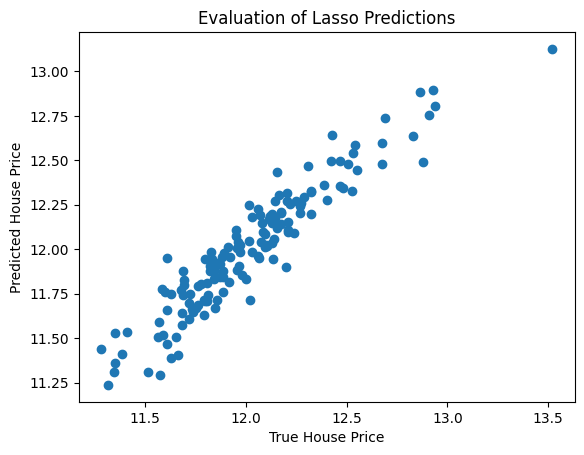

In [17]:
# let's evaluate our predictions respect to the real sale price
plt.scatter(y_test, price_pipeline.predict(X_test))
plt.xlabel('True House Price')
plt.ylabel('Predicted House Price')
plt.title('Evaluation of Lasso Predictions')

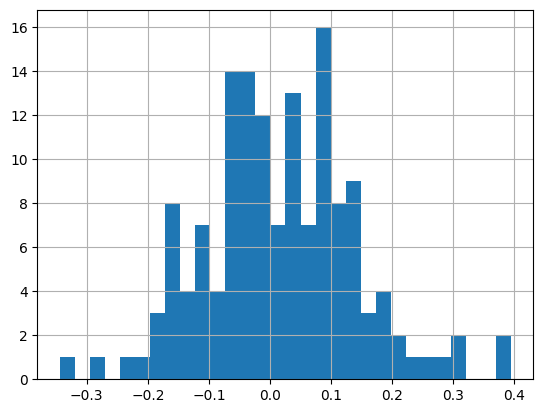

In [18]:
# let's evaluate the distribution of the errors: 
# they should be fairly normally distributed

y_test.reset_index(drop=True, inplace=True)

preds = pd.Series(price_pipeline.predict(X_test))

errors = y_test - preds
errors.hist(bins=30)
plt.show()

## Save pipeline

In [21]:
joblib.dump(price_pipeline, Path.joinpath(SRC_PATH, 'models/price_pipe.joblib'))

['/Users/juandiegogallegoquiceno/Desktop/PersonalProjects/mlops/deployment-ml-models/src/models/price_pipe.joblib']

# Score on new data

In [22]:
data = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'))
data.drop('Id', axis=1, inplace=True)
data['MSSubClass'] = data['MSSubClass'].astype('O')
data = data[FEATURES]
print(data.shape)

(1459, 37)


In [23]:
# lets see if theres variables with nans that were not
# transformed on saved pipeline
new_vars_with_na = [
    var for var in FEATURES
    if var not in CATEGORICAL_VARS_WITH_NA_FREQUENT +
    CATEGORICAL_VARS_WITH_NA_MISSING +
    NUMERICAL_VARS_WITH_NA
    and data[var].isnull().sum() > 0]

new_vars_with_na

['MSZoning',
 'Exterior1st',
 'BsmtFullBath',
 'KitchenQual',
 'Functional',
 'GarageCars',
 'GarageArea']

In [24]:
data[new_vars_with_na].isnull().mean()

MSZoning        0.002742
Exterior1st     0.000685
BsmtFullBath    0.001371
KitchenQual     0.000685
Functional      0.001371
GarageCars      0.000685
GarageArea      0.000685
dtype: float64

In [25]:
# drop rows with nans on the previously varibles
data.dropna(subset=new_vars_with_na, inplace=True)
print(data.shape)

(1449, 37)


<Axes: >

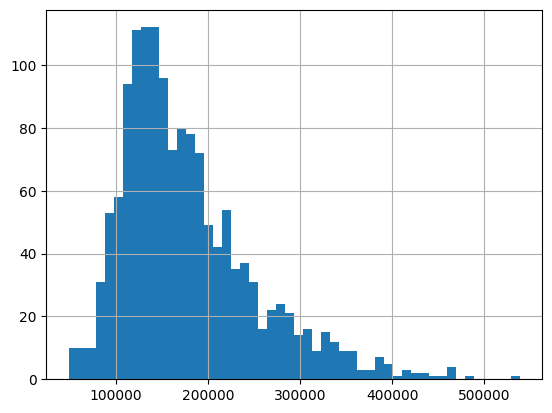

In [28]:
# get preds on test
new_preds = price_pipeline.predict(data)
# now evaluate predictions
pd.Series(np.exp(new_preds)).hist(bins=50)